<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 13 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 8 December 2022</div>

Let's wrap our semester with a notebook about designing a statistical experiment. What are all the factors to consider? How to compare frequentist and Bayesian approaches?

# Designing a statistical experiment: A-B testing in depth

A student of mine interviewed for Amazon and told me they told her to study A/B tests for her next interview. So I thought I would do a lecture with an A/B test notebook with you.

We already did A/B tests with an IQ pill and romantic sloths, but let's do it again in depth, where we learn *everything* there is to learn about A/B tests and we also contrast a frequentist with a Bayesian approach.

An A/B test is a simple *controlled experiment*. Let’s say we want to learn if a new UI is good for users.

To run the experiment, we take a subset of users or user sessions, usually a simple random sample, and then use random assignment to evenly split that sample into two groups. Group `A` often called the **control group**, continues to receive the old UI, while Group `B`, often called the **treatment group**. Group B receives the new UI.

We wait, and we then compare the values of a variety of metrics from Group A to those from Group B. Some metrics will be specific to the given hypothesis. For a UI experiment, we’ll look at engagement with different variants of the new feature. For an experiment that aims to enage the users more, we’ll measure if members are using the app a bit more. In other types of experiments, we might focus on more technical metrics, such as the time it takes the app to load.

There’s a lot of statistics involved as well — how large a difference is considered significant? How many members do we need in a test in order to detect an effect of a given magnitude? How do we most efficiently analyze the data?

Because we create our control and treatment groups using random assignment, we can ensure that individuals in the two groups are, on average, balanced on all dimensions that may be meaningful to the test. The only remaining difference between the groups is the new experience we are testing, ensuring our estimate of the impact of the new experience is not biased in any way.

Do we really know that the new product experience is what caused the increase in engagement? What other explanations are possible? What if you also knew that the UI gave users a rebate on a product? Now we have more than one possible explanation for the increase in engagement: it could be the new product experience, it could be saving money. The key point is that we don’t know if the new product experience caused the increase in engagement.

Here's an example where if we did ***not*** do an A/B test, we may be drawn to conclude that our new UI results in better user conversion (or engagement), whereas, it really does not. If we release a new vesion of a package and then we see an improvement
in the engagement of users, we might be drawn to conclude cause and effect. But if we were more careful and we continued to sample both products as in the graph on the right, we can see that something else caused that jump in engagement, not the new release.

<br />
<center>
<img src="ipynb.images/a-b-testing-1.png" width=900 />
</center>

>**Important**: Running A/B tests, where possible, allows us to substantiate *causality* and confidently make changes to the product knowing that our members have voted for them with their actions.

There is a lot of statistics related to A/B tests, so this notebook is a good review before data science interviews.

First, we import some libraries:

In [2]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

# Testable hypothesis

We next turn this idea into a **testable hypothesis**, a statement of the form `If we make change X, it will improve the member experience in a way that makes metric Y improve`. 

There are two types of mistakes we can make in acting on test results:

A **false positive** (also called a **Type I error**) occurs when the data from the test indicates a meaningful difference between the control and treatment experiences, but in truth there is *no* difference (I call this an ***eager beaver*** error). 

>**Type I error**: This scenario is like having a medical test come back as positive for a disease when you are healthy. Oh no!

The other error we can make in deciding on a test is a **false negative** (also called a **Type II error**), which occurs when the data do not indicate a meaningful difference between treatment and control, but in truth there *is* a difference (I call this a ***lazy sloth*** error). 

>**Type II error**: This scenario is like having a medical test come back negative — when you do indeed have the disease you are being tested for. Oh no!

We need to make one of two decisions based on the data:
- Sufficient evidence to conclude that the new UI affects member satisfaction, or 
- Insufficient evidence

There are two possible truths, that we never get to know with complete certainty.

For a given F1 season, there are two possible decisions (LH or MV), well, more really, but let's just say these two are the most talented drivers by far, and likewise there are two possible truths (winner or loser). This leads to a total of four possible outcomes, shown in the figure below. 

The same is true with A/B tests: we make one of two decisions based on the data (`sufficient evidence to conclude that the new UI affects member satisfaction` or `insufficient evidence`), and there are two possible truths, that we never get to know with complete uncertainty (`New UI truly affects member satisfaction` or `it does not`).

If there are two possible outcomes and two possible actors for each outcome, that's a total of 4 possibilities, expressed below as true/false positive/negatives:

<br />
<center>
<img src="ipynb.images/a-b-testing-2.png" width=900 />
</center>

# Eager beaver: False positives, p-value, and statistical significance

<br />
<center>
<img src="ipynb.images/eager-beaver.png" width=300 />
</center>

With a sound hypothesis and a clear understanding of the primary decision metric, we turn to the statistical aspects of designing an A/B test. 

This process generally starts by fixing the **acceptable false positive rate**. 

By convention, this false positive rate is usually set to 5%: for tests where there is not a meaningful difference between treatment and control, we’ll falsely conclude that there is a *statistically significant* difference 5% of the time. 

Tests that are conducted with this 5% false positive rate are said to be run at the 5% **significance level**.

This false positive rate is closely associated with the statistical significance of the observed difference in metric values between the treatment and control groups, which we measure using the **p-value**. 

The p-value is the probability of seeing an outcome at least as extreme as our A/B test result, had there truly been no difference between the treatment and control experiences. 

The p-value tells us how sensitive we are to wide swings in statistical difference. If it's large, don't worry that much about differences in point estimates, they are probably due to chance. If it's small and you see differences in point estimates, it probably means the statistics *are* different and there is a very definite mechanism that is causing this (e.g. a pill that cures, more talent than before, etc.).

The p-value is not the probability that the null hypothesis is true! The p-value is only the probability of observing results as extreme or more extreme than the observed data, given that the null hypothesis is true.

>**Fact**: It is known that the p-value often overstates the evidence against the null hypothesis. Which is why pharamceuticals often use this statistic to justify to the FDA that their drug works and should be marketed. However, the opposite might also occur sometimes, as we saw in our IQ notebook.

Here's an intuitive way to understand statistical significance and p-values, which have been confusing students of statistics for over a century.

Say we want to know if LH is a better or worse driver than MV, in the sense that the probability of LH beating MV in a head-to-head race is *not* 0.5 (or 50%). 

This is called a [two-tailed test](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests):

To decide, let’s run the following experiment: we'll have LH and MV race each other 100 times and tally up wins. Because of randomness, weather conditions, tire pressures, or *noise*, we wouldn’t expect exactly 50 wins and 50 losses for LH. But how much of a deviation from 50 is *too much*? When do we have sufficient evidence to reject the baseline assertion that LH and MV are just as good? 

Would you be willing to conclude that LH is better if he wins 60 out of 100 races? 70? 

We need a way to align on a decision framework and understand the associated false positive rate.

To build intuition, let’s run through a thought exercise.

First, we’ll assume that LH and MV are just as good F1 drivers — this is our **null hypothesis**, which is always a statement of **status quo**, **equality**, or **nothing interesting happening**. 

We then seek compelling evidence against this null hypothesis from the data.

### 1. Build null hypothesis hypothetical (look at black and blue bars only)
To make a decision on what constitutes compelling evidence, we first calculate the ***theoretical probability*** of every possible outcome, assuming that the null hypothesis is true. 

For F1, that’s the probability of 100 races yielding zero wins for LH, one win, two wins, and so forth up to 100 wins — assuming that both drivers are just as talented. 

Skipping over the math, each of these possible outcomes and their associated probabilities are shown with the black and blue bars in the figure below (ignore the colors for now). Some of these bars are more probable than others. If the null hypothesis is in effect, 50% is the most likely amongst all possibilities.

<br />
<center>
<img src="ipynb.images/a-b-testing-3.png" width=900 />
</center>

### 2. Compare with observation (solid red line)
We can then compare this probability distribution of outcomes, calculated under the assumption that both drivers are as talented, to the data we’ve collected: Our ***observations***.

Say we observe that 55% of 100 races are LH wins (the solid red line in the figure above). To quantify if this observation is compelling evidence that LH is more talented, we count up the probabilities associated with every outcome that is less likely than our observation (the red arrows). 

### 3. Sum probabilities outside (outside both red lines)
Here, because we’ve made no assumptions about win or loss being more likely, we sum up the probabilities of 55% ***or more*** of the races ending up as wins for LH (the bars to the right of the solid red line) and the probabilities of 55% ***or more*** of the races coming up as losses for LH (the bars to the left of the dashed red line).

And this is the mythical **p-value**! The probability of seeing a result ***as extreme as our observation***, if the null hypothesis were true. In our case, the null hypothesis is that both drivers are as talented, say the observation is 55% wins for LH in 100 races, and the p-value is about 0.32. 

The interpretation is as follows: Were we to repeat, many times (a.k.a. may samplings, or many parallel universes), the experiment of 100 LH/MV races and calculating the fraction of wins, with an equally talented predicate (the null hypothesis is true), then *in 32% of those experiments the outcome would feature at least 55% wins or at least 55% losses (results at least as unlikely as our actual observation)*.

### 4. Compare with false positive accepted rate
How do we use the p-value to decide if there is **statistically significant** evidence that one driver is more talented that the other? 

It comes back to that 5% false positive rate that we agreed to accept at the beginning: We conclude that there is a statistically significant effect if the p-value is less than 0.05. 

This formalizes the intuition that we should reject the null hypothesis that the drivers are qually as talented if our result is **sufficiently unlikely** to occur under the assumption of an equal talent level. 

In the example of observing 55 wins out of 100 head to head races, we calculated a p-value of 0.32. Because the p-value is larger than the 0.05 significance level, we conclude that there is *not statistically significant evidence that one driver is more talented than the other*.

There are two conclusions that we can make from an experiment or A/B test: we either conclude there is an **effect** (*one driver is more talented than the other*, `the new UI increases member satisfaction`) or we conclude that there is *insufficient evidence to conclude there is an effect* (*cannot conclude that one driver is more talented*, `cannot conclude that the new UI increases member satisfaction`). 

The p-value is the Bernoulli-like decider on the effect. It is not a probability!

In a race, where the two possible outcomes are *winner* or *loser* — *loser* is very different from *less talented* (I know, because I'm very talented in Tennis but I loose all the time! ;-)

This (frequentist) approach to A/B testing when the p-value exceeds the threhsold does not allow us to make the conclusion that there is no effect — we never conclude one driver is better than the other, or that the new UI has no impact on our members. We just conclude we’ve *not collected enough evidence to reject the null assumption that there is no difference*. We observed 55% wins out of 100 races, and concluded we had insufficient evidence to label one driver as more talented. 

If we gathered more evidence, say with 1000 races, we might find sufficiently compelling evidence to reject the null hypothesis of an equal amount of talent.

# Rejection Regions and Confidence Intervals
There are two other concepts in A/B testing that are closely related to p-values: The **rejection region** for a test, and the **confidence interval** for an observation. 

### Rejection Regions
Another way to build a decision rule for a test is in terms of what’s called a **rejection region** — the set of values for which we’d conclude that one driver is more talented. 

To calculate the rejection region, we once more assume the null hypothesis is true (equal amount of talent), and then define the rejection region as the set of least likely outcomes with probabilities that sum to no more than 0.05. 

The rejection region consists of the outcomes that are the most extreme — the outcomes where the evidence against the null hypothesis is strongest. 

If an observation falls in the rejection region, we conclude that there *is* statistically significant evidence that one of the two drivers is more talented, and *reject* the null hypothesis. 

In the case of our races, the rejection region corresponds to observing fewer than 40% or more than 60% wins for one driver (shown with blue shaded bars in the figure above). We call the boundaries of the rejection region, here 40% and 60% wins, the **critical values** of the test.

There is an equivalence between the rejection region and the p-value, and both lead to the same decision: the p-value is less than 0.05 if and only if the observation lies in the rejection region.

### Confidence Intervals
So far, we’ve approached building a decision rule by first starting with the null hypothesis, which is always a statement of no change or equivalence (*equal talent* or `the new UI does not impact member satisfaction`). 

We then define possible outcomes under this null hypothesis and compare our observation to that distribution. 

To understand confidence intervals, it helps to flip the problem around to focus on the observation. We then go through a thought exercise: given the observation, what values would lead to a decision not to reject the null hypothesis of equal talent, assuming we specify a 5% false positive rate? 

The answer is an observation of 55% wins in 100 races and we do not reject the null hypothesis of equal talent. 

Nor would we reject the null hypothesis if the probability of wins was 47.5%, 50%, or 60%. 

There’s a whole range of values for which we would not reject the null, from about 45% to 65% probability of wins (Figure below).

This range of values is a **confidence interval**: The set of values under the null hypothesis that would *not* result in a rejection of the null hypothesis, given the data from the test. 

Because we’ve mapped out the interval using tests at the 5% significance level, we’ve created a **95% confidence interval**. 

The interpretation is that, under repeated experiments, the confidence intervals will cover the true value (here, the actual probability of wins) 95% of the time.

There is an equivalence between the confidence interval and the p-value, and both lead to the same decision: the 95% confidence interval does not cover the null value if and only if the p-value is less than 0.05, and in both cases we reject the null hypothesis of equal talent.

Consider what happens as the null hypothesis (black curve below) coincides with observations (red line and red shaded area lying between rejection regions below):
- If the peak of the null hypothesis is within the rejection region (outside the red shaded area), we ***reject*** the null hypothesis
- If the peak of the null hypothesis is outside of the rejection region (inside the red shaded area), we ***accept*** the null hypothesis

<br />
<center>
<img src="ipynb.images/a-b-testing-4.png" width=900 />
</center>

So, we’ve built up intuition about false positives, statistical significance and p-values, rejection regions, confidence intervals, and the two decisions we can make based on test data. 

These core concepts and intuition map directly to comparing treatment and control experiences in an A/B test. We define a *null hypothesis* of no difference: the `B` experience does not alter affect member satisfaction. 

We then play the same thought experiment: what are the possible outcomes and their associated probabilities for the difference in metric values between the treatment and control groups, assuming there is no difference in member satisfaction? 

We can then compare the observation from the experiment to this distribution, just like with F1 races, calculate a p-value and make a conclusion about the test. And we can define rejection regions and calculate confidence intervals.

But false positives are only one of the two mistakes we can make when acting on test results. The other type of mistake is a **false negative**, and the closely related concept is that of **statistical power**.

# Lazy sloth: False negatives and statistical power

<br />
<center>
<img src="ipynb.images/lazy-sloth.png" width=350 />
</center>

A **false negative** occurs when the data do not indicate a meaningful difference between treatment and control, but in truth there is a difference. 

False negatives are closely related to the concept of **statistical power**, which gives the probability of a true positive given the experimental design and a true effect of a specific size. 

In fact, statistical power is simply one minus the false negative rate $\beta$.

Power involves thinking about possible outcomes given a specific assumption about the actual state of the world — similar to how we defined significance by first assuming the null hypothesis is true. 

To build intuition about power, let’s try to decide if one driver is more talented than the other using an experiment that calculates the fraction of wins out of 100 races. 

The distribution of outcomes under the null hypothesis that the amount of talent is equal is shown in black the figure below, peaking at 50%.

Let’s work through what happens when we have a set of 100 races where, on average, 64% of the time, one driver wins. 

<br />
<center>
<img src="ipynb.images/a-b-testing-5.png" width=600 />
</center>

Because there is uncertainty or noise in our experiment, we don’t expect to see exactly 64 wins out of 100 races. But as with the null hypothesis that the talent is equaly distributed, we can calculate all possible outcomes if this specific **alternative hypothesis** is true. This distribution is shown with the red curve on the figure above, peaking at 64%.

Visually, **power** is the difference between black (null hypothesis) and red (alternative hypothesis): The fraction of the alternative (red) distribution that lies *beyond* the critical values under the null hypothesis (the blue lines and black curve). 

Here, 80% of the alternative distribution (red) falls to the right of the taller blue line that demarcates the critical value of the upper rejection region. 

Assuming that the truth about the coin is that the probability of a win is 64%, then the power of this test is 80%. 

To be complete, there could also be a small part of the alternative (red) distribution that falls within the lower rejection region (to the left of the short blue line).

The power of a test corresponds to a specific, postulated **effect size**. 

In our example, if in our test 64% of the time one driver wins, our test has 80% power to detect that one driver is more talented. 

The interpretation is as follows: if LH has a probability of winning of 64% compared to MV, and we repeatedly run the experiment of head to head race 100 times, and we make a decision at the 5% significance level, then we will correctly reject the null hypothesis that there is an equal amount of talent in about 4 out of every 5 experiments (80%). 

In other words, we are looking for an effect 14% above 50-50.

And 20% of those repeated experiments will result in a false negative: we won't reject the null hypothesis that the talent is equally distributed, even though it really is.

## Ways to increase power
In designing an A/B test, we first fix the significance level (the convention is 5%: if there is no difference between treatment and control, we’ll see false positives 5% of the time), and then design the experiment to control false negatives.

There are three primary levers we can pull to increase power and reduce the probability of false negatives:

### 1. Increase Effect size
Simply put, the larger the effect size — the difference in metric values between Groups A and B — the higher the probability that we’ll be able to correctly detect that difference. 

To build intuition, think about running an experiment to determine talent, where the data we collect is the fraction of wins in 100 races. 

Now think of two scenarios. In the first scenario, the true probability of a win 55%, and in the second it is 75%. 

Intuitively, it is more likely that our experiment identifies that one driver is more talented in the second scenario. 

The true probability of wins is further from the null value of 50%, so it’s more likely that an experiment will produce an outcome that falls in the rejection region. 

We could for example give both drivers *shitty cars* to drive ;-)

In a better UI context, we can increase the expected magnitude of metric movements by being *bold* (switch to React from Angular) vs *incremental* (improve our Angular) with the hypotheses we test. 

Another strategy to increase effect sizes is to test in new areas of the product, where there may be room for larger improvements in member satisfaction. That said, one of the joys of learning through experimentation is the element of surprise: at times, seemingly small changes can have a major impact on top-line metrics.

### 2. Increase Sample size
The more races in the experiment, the higher the power and the easier it is to correctly identify smaller effects. 

To build intuition, think again about running an experiment to determine talent, where the data we collect is the fraction of wins in a fixed number of races and the true probability of a win is 64%. 

Consider two scenarios: in the first, we race 20 times, and in the second, we race 100 times. 

Intuitively, it is more likely that our experiment identifies one driver is more  talented in the second scenario. 

With more data, the result from the experiment is going to be closer to the true rate of 64% win probability, while the outcomes under the assumption of equal amount of talent concentrate around 0.50, causing the rejection region to encroach on the 50% value. 

These effects combine, so that with more data there is a greater probability that the result from the experiment where one driver is more talented will fall in that rejection region, resulting in a true positive. 

In a better UI context, we can increase the power by allocating more members to the test or by reducing the number of test groups.

### 3. The variability of the metric in the underlying population
The more homogenous the metric within the population we are testing on, the easier it is to correctly identify true effects. 

The intuition for this one is a bit trickier, and our UI examplar finally breaks down. Say that we run a test that aims to reduce some measure of latency, such as the delay between a member pressing play and video playback commencing. Given the variety of devices and internet connections that people use, there is a lot of natural variability in this metric across users. As a result, if the test treatment results in a small reduction in the latency metric, it’s hard to successfully identify what is going on — the *noise* from the variability across members overwhelms the small signal. 

In contrast, if we ran the test on a set of members that used *similar* devices with *similar* web connections, then the small signal is easier to identify — there is less noise that might drown out the signal. 

Thus, it is important to spend a lot of time building statistical analysis models that exploit this intuition, and increase power by effectively lowering variability.

## Powering for reasonable and meaningful effects
Power and the false negative rate are functions of a postulated effect size. 

Much like how the 5% false positive rate is a widely-accepted convention, the rule of thumb with power is to aim for 80% power for a reasonable and meaningful effect size. 

That is, we postulate an effect size and then design the experiment, primarily through setting the sample size, such that, if the true impact of the treatment experience is as we’ve postulated, the test will correctly identify that there is an effect 80% of the time. 

And 20% of the time the result from the test will be a false negative: in truth, there is an effect, but our observation from the test does not lie in the rejection region and we fail to conclude that there is an effect. 

That’s why the examples above used a 64% probability of wins: An experiment with 100 races then has 80% power.

What constitutes a reasonable effect size can be tricky, as tests can surprise us. But a mix of domain knowledge and common sense can generally provide solid estimates. 

In an area where testing has a long history, companies have a solid idea about the effect sizes that their tests tend to produce (be they positive or negative). 

Given an understanding of past effect sizes, as well as the analysis strategy, companies can set the sample size to ensure the test has 80% power for a reasonable metric movement.

The second consideration, both in this experimental design phase and in deciding where to invest efforts, is to determine what constitutes a meaningful impact to the primary metrics used to decide the test. 

What is meaningful will depend on the impact area of the experiment (member satisfaction, playback latency, technical performance of back end systems, etc.), and potentially the effort or costs associated with the new product experience. 

As a hypothetical, say that, for effect sizes smaller than a 0.1% change in the primary metric (what we'll see in our experiment at the end of this notebook), the cost of supporting the new product feature outweighs the benefits. In this case, there’s little point in powering a test to detect a 0.01% change in the metric, as successfully identifying an effect of that size won’t result in a meaningful change in decisions. Likewise, if the effect sizes seen in tests in a given innovation area are consistently immaterial to the user experience or the business, that’s a sign that experimentation resources can be more efficiently deployed somewhere else.

This is called doing a [power analysis](https://en.wikipedia.org/wiki/Power_of_a_test).

# Conclusion
An uncomfortable truth about experimentation is that we can’t simultaneously minimize both false positives and false negatives.

In fact, false positives and negatives trade off with one another. 

If we used a more stringent false positive rate, such as 0.01%, we’d reduce the number of false positives for tests where there is no difference between A and B — but we’d also reduce the power of the test, increasing the rate of false negatives, for those tests where there is a meaningful difference. 

>**Empirical fact**: Using a 5% false positive rate and targeting 80% power are well-established conventions that balance between limiting false discovery and enabling true discovery. 

However, in instances where a false positive (or false negative) poses a larger risk, researchers may deviate from these rules of thumb to minimize one type of uncertainty over another!

Our goal is not to eliminate uncertainty, but to understand and quantify the uncertainty in order to make sound decisions. 

In many cases, results from A/B tests require nuanced interpretation, and in fact the test result itself is only one input into a business decision. 

# Designing an experiment
Let's go over the process of analysing an A/B experiment, from formulating a hypothesis, testing it, and finally interpreting results, from both a frequentist and a Bayesian perspective.

We’ll use a dataset I downloaded from [kaggle](https://www.kaggle.com/ivanpl/a-b-testing/data) which contains the results of an A/B test on what seems to be 2 different designs of a website page (old UI vs. new UI). Let's hypothesize it's selling shampoos.

<br />
<center>
<img src="ipynb.images/shampoos.png" width=300 />
</center>

Suppose the product manager (PM) tells you that the current **conversion rate** (how many people buy the shampoo over how many people view the Web page) is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new UI design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of your user base users.

## 1. Formulating a hypothesis
First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.

Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a [two-tailed test](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests):

$$Hₒ: p = pₒ$$

$$Hₐ: p ≠ pₒ$$

where $p$ and $pₒ$ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:

$$α = 0.05$$

The $α$ value is a threshold we set, by which we say `if the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the Null hypothesis`. Since $α=0.05$ (indicating 5% probability), our confidence $(1 — α)$ is 95%.

## 2. Choosing the variables
For our test we’ll need two groups:
- A control group - They'll be shown the *old* UI
- A treatment (or experimental) group - They'll be shown the *new* UI

This will be our **independent variable**. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as **seasonality**. By having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs. See the first figure in this notebook to understand why having two groups is important.

For our **dependent variable** (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:
- 0 - The user did not buy the product during this user session
- 1 - The user bought the product during this user session

This way, we can easily calculate the mean for each group to get the conversion rate of each design.

Let's do the first step of programming: *naming variables*!

Suppose that we have obtained data from $n$ visitors, $n_A$ of which have been (randomly) sent to the old page $A$ and $n_B$ of which have been sent to new page $B$. 

Further, let $X_A$ and $X_B$ denote the number of visitors for whom we obtained a *successful* outcome (a conversion, a buy!) in the two groups. The proportion of successes in the two groups is then given by $p_A = \frac{X_A}{n_A}$ and $p_B = \frac{X_B}{n_B}$ respectively.

The estimated difference in conversion rates is then give by the difference in proportions:  $p_A − p_B$.

To assess whether we have statistical evidence that the two pages' conversion rates truly differ, we perform a **hypothesis test**:
- The **null hypothesis** that we want to test for is that the two pages' conversion rates are equal
- The **alternative** is that they differ (one is higher than the other). 

If $p_A = $ the proportion of the page $A$ population whom we obtained a successful outcome (conversion), and $p_B =$ the proportion of the page $B$ population whom we obtained a successful outcome (conversion, then we are interested in testing the following hypothesis:

$H_0: p_A = p_B$ versus $H_1: p_A ≠ p_B$.
 
Or put it in another way, the null hypothesis says that the factors `page version` and `outcome` are statistically *independent* of each other. In words, this means knowing which page someone is sent to tells you nothing about the chance that they will have a successful outcome. Now that we know what hypothesis test we're interested in, we'll have to derive the appropriate test statistic.

## 3. Choosing a sample size
It is important to note that since we won’t test the whole user base (our population), the conversion rates that we’ll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.
So how many people should we have in each group?

The sample size we need is estimated through something called [Power analysis](https://en.wikipedia.org/wiki/Power_of_a_test), and it depends on a few factors:
- Power of the test $(1 — β)$ — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention

- Alpha value ($α$) — The critical value we set earlier to 0.05

- Effect size — How big of a difference we wish to observe between conversion rates

Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

## Review 
**Statistical inference** is the process of analyzing **sample data** to gain insight into the population from which the data was collected and to investigate differences between data samples. 

**Point estimates** are estimates of population parameters based on sample data, resulting from some kind of aggregation operation. 

For instance, if we wanted to know the average age of students at NU, we could take a survey of students and then use the average age of the respondents as a point estimate of the average age of NU students as a whole. The average of a sample is known as the **sample mean**. 

The sample mean is usually not exactly the same as the population mean. This difference can be caused by many factors including the randomness inherent to drawing a sample from a population. 

In data analysis, we are often interested in the characteristics of some large population, but collecting data on the entire population may be infeasible. 

The [Central Limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) is one of the most important results of probability theory and serves as the foundation of many methods of statistical analysis. 

>**Central Limit theorem**: At a high level, the theorem states the distribution of many sample means, known as a sampling distribution, will be normally distributed! This rule holds even if the underlying distribution itself is not normally distributed! As a result we can treat the sample mean as if it were drawn normal distribution. 

That is why probabilistic and statistical methods that work for normal distributions can be applicable to many problems involving other types of distributions. Here's an illustrative example (we already did this with the Celtics, but it's important enough and tends to be an interview question so I'll do it again): We concatenate two Poisson distributions to obtain a bimodal (two-humped) dataset and investigate point estimates by drawing a sample from it to estimate the mean:

In [3]:
# generate some random number to serve as our population
np.random.seed(10)
population_ages1 = stats.poisson.rvs(loc = 18, mu = 35, size = 150000)
population_ages2 = stats.poisson.rvs(loc = 18, mu = 10, size = 100000)
population_ages = np.concatenate((population_ages1, population_ages2))
print('population mean:', np.mean(population_ages))

population mean: 43.002372


Let's sample 500 data points:

In [4]:
np.random.seed(6)
sample_ages = np.random.choice(population_ages, size = 500)
print('sample mean:', np.mean(sample_ages))

sample mean: 42.388


Real world data is often *not normally distributed* (I know that from all the parking tickets I get!) and the distribution of a sample tends to mirror the distribution of the population. This means a sample taken from a population with a skewed distribution will also tend to be skewed:

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


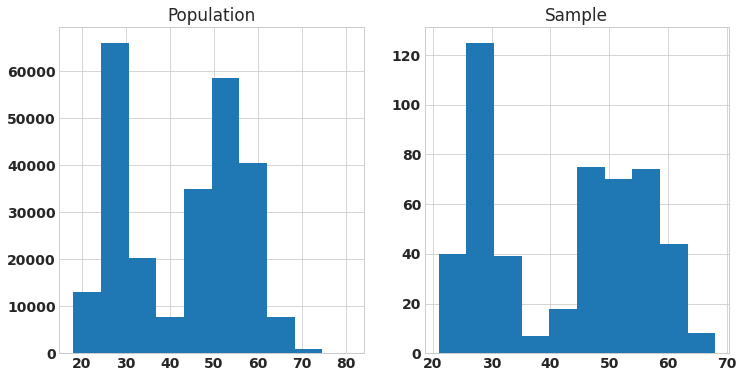

In [5]:
fig = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.hist(population_ages)
plt.title('Population')
plt.subplot(1, 2, 2)
plt.hist(sample_ages)
plt.title('Sample')
plt.show()

The plots reveal that the data is clearly not normal: instead of one symmetric bell curve, it has as bimodal distribution with two high density peaks. Because of this, the sample we drew from this population should have roughly the same shape and skew.

The sample indeed has roughly the same shape as the underlying population. Does this mean that we can't apply techniques that assume a normal distribution to this data set, since it is not normal?

*No*!

The central limit theorem states that the distribution of many sample means, known as a sampling distribution, will be normally distributed. This rule holds even if the underlying distribution itself is not normally distributed. As a result we can treat the sample mean as if it were drawn normal distribution. To illustrate, let's create a sampling distribution by taking 200 samples from our population and then making 200 point estimates of the mean.

In other words, we repeat what we did above, but we repeat it 200 times with a list comprehension:

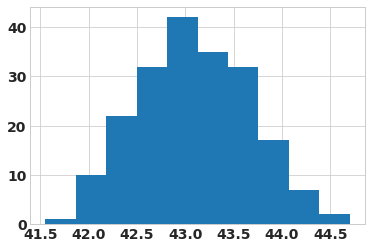

In [6]:
np.random.seed(10)
samples = 200
point_estimates = [np.random.choice(population_ages, size = 500).mean()
                   for _ in range(samples)]

plt.hist(point_estimates)
plt.show()

Wow, well how about that?! The sampling distribution appears to be roughly normal, despite the bimodal population distribution that the samples were drawn from. 

In addition, the mean of the sampling distribution approaches the true population mean:

In [ ]:
population_ages.mean() - np.mean(point_estimates)

So if we collect *a large number* of different sample means from the population, the sampling distribution, the distribution of the sample means collected, will approximately take the shape of a normal distribution around the population mean *no matter what the orginal population distribution is*.

Of course, that implies a lot of sampling, but this procedure is essential in order to be able to apply classical frequentist results that most of the time depend on gaussian (or student-T) profiles.

>**Note**: In machine learning, the equivalent concept is [k-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) resampling.

>**Note**: p-values are based on calculating the probability of observing test statistics that are as extreme or more extreme than the test statistic actually observed, which relies on hypothetical repeated samples, which we do not observe. Sometimes, they're described derisively **parallel universes** by Bayesians that prefer relying on observed data rather than repeated sampling (one per universe).

So, for a concrete example, I would like to give you homework, my dear class, to tell me what are *my chances of marrying Dua Lipa*. 

<br />
<center>
<img src="ipynb.images/dua-lipa-marry-professor.jpg" width=500 />
</center>

So you say, ok, there are many professors that want to marry Dua Lipa out in the world (and that have very small pickings to that claim). How would you design an experiment for this? Let's go sampling!

I'm going to go sample in India, then in China, then in Greece, then in the US, then across all rich countries of the world, then across all poor countries, then across all cold countries, then across all warm-weather countries, etc. That way, I'm going to generate *many* samplings. For each sampling, I'm going to perform an aggregation operation: An operation yielding a point estimate, such as mean or a higher order moment, telling me something about professors marrying Dua Lipas. Then I'm going to put all these point estimates together to generate a pdf that, or so the Central Limit Theorem tells me, should look like a normal distribution. 

Then I'm going to build myself a null hypothesis: ***Can't tell a difference between professors or rock stars marrying other rock stars in the general population***, and an alternative hypothesis: ***Professors do not marry Dua Lipas, are you crazy?!***  And then I'm going to use a z-test (normal likelihoods), or a t-test (student-T likelihoods), or ..., to generate a p-value that will tell me the probability of observing the results I observe if the null hypothesis is in effect. Based on the p-value and the observations, I'll be able to tell professor if he should propose to Dua Lipa, or whether he should probably not waste his time or ego. And then, you get an A for the class :-)

>**Bayesian science**: A Bayesian scientist would also sample to generate observations, but he would proceed differently. Instead of generating point estimates from different samplings, she would look at the histogram of all the observations (samples), decide on a likelihood function, figure out pdfs for the parameters, build two different models (marries Dua Lipa, does not marry Dua Lipa), perform mcmc simulations to match the model with the observations, and then use the Bayes factor to figure out which model is more likely to match observations (more on this later). And you also get an A :-)

A **point estimate** can give us a rough idea of a population parameter like the mean, but estimates are prone to error. A **confidence interval** is a range of values above and below a point estimate that captures the true population parameter at some predetermined confidence level. For example, if you want to have a 95% chance of capturing the true population parameter with a point estimate and a corresponding confidence interval, we'd set our confidence level to 95%.

>**Note**: Confidence intervals is how frequentist statisticians try to get a hold of the standard deviation (error) of the point estimate. In truth, it's a much poorer alternative to Bayesian standard deviations!

This is how frequentists determine confidence intervals:

In [ ]:
np.random.seed(10)
red = sns.xkcd_rgb['vermillion']
blue = sns.xkcd_rgb['dark sky blue']

sample_size = 1000
sample = np.random.choice(population_ages, size = sample_size)
sample_mean = sample.mean()

confidence = 0.95
z_critical = stats.norm.ppf(q = confidence + (1 - confidence) / 2)
print('z-critical value:', z_critical)                     

pop_stdev = population_ages.std()
margin_of_error = z_critical * (pop_stdev / np.sqrt(sample_size))
confint = sample_mean - margin_of_error, sample_mean + margin_of_error
print('point esimate:', sample_mean)
print('Confidence interval:', confint)

Notice that the confidence interval we calculated captures the true population mean of 43.0023. 

Let's create several confidence intervals and plot them to get a better sense of what it means to "*capture*" the true mean:

In [ ]:
np.random.seed(12)
confidence = 0.95
sample_size = 1000

intervals = []
sample_means = []
for sample in range(25):
    sample = np.random.choice(population_ages, size = sample_size)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)

    z_critical = stats.norm.ppf(q = confidence + (1 - confidence) / 2)                    
    pop_std = population_ages.std()
    margin_error = z_critical * (pop_stdev / np.sqrt(sample_size))
    confint = sample_mean - margin_error, sample_mean + margin_error 
    intervals.append(confint)
    

plt.figure(figsize = (10, 8))
plt.errorbar(x = np.arange(0.1, 25, 1), y = sample_means, 
             yerr = [(top - bot) / 2 for top, bot in intervals], fmt = 'o')

plt.hlines(xmin = 0, xmax = 25,
           y = population_ages.mean(), 
           linewidth = 2.0, color = red)
plt.show()

Notice that in the plot above, all but one of the 95% confidence intervals (error bars) overlap the red line marking the true mean. This is to be expected: Since a 95% confidence interval captures the true mean 95% of the time, we'd expect our interval to miss the true mean 5% of the time.

More formally, the definition of a 95% confidence interval means that 95% of confidence intervals, created based on random samples of the same size from the same population will contain the true population parameter.

## End of review, back to our experiment

Ok, we already did A/B tests with IQ medicine (works/doesn't), but let's do it again. An A/B test involves a **null hypothesis** and an **alternative hypothesis**.

We conduct a hypothesis test under the assumption that the null hypothesis is true. If the test results suggest that the data do not provide convincing evidence for the alternative hypothesis, we stick with the null hypothesis. If they do, then we reject the null hypothesis in favor of the alternative.

Frequentist statistic's hypothesis testing uses a **p-value** to weigh the strength of the evidence (what the data is telling us). p-value is defined as the probability of obtaining the observed or more extreme outcome, given that the null hypothesis is true (*not the probability that the alternative hypthesis is true*). It is a number between 0 and 1 and interpreted in the following way:

- A small p-value (typically <= 0.05, 0.05 is a commonly used threshold, the threshold is often denoted as  α) indicates **strong evidence** against the null hypothesis, so we reject the null hypothesis. This means that something interesting is going on and it’s not just noise!
- A large p-value (> 0.05) indicates **weak evidence** against the null hypothesis, so we fail to reject the null hypothesis. - -Although p-value is still in our favor, we cannot conclusively say that it was not due to random noise.
- p-values very close to the cutoff (0.05) are considered to be **marginal** (could go either way, also called *anecdotal*, even though this terminology is usualy reserved to Bayesian approaches). If you carefully read good papers on these kind of topics, you will always see the p-values being *reported* so that the readers can draw their own conclusions. I so wish politicians would do the same thing about their assertions!!

We start with a *frequentist* approach:

### Classical frequentist statistics
In statistics, an [effect size](https://en.wikipedia.org/wiki/Effect_size) is a number measuring the strength of the relationship between two variables in a population, or a sample-based estimate of that quantity. 

Examples of effect sizes include the correlation between two variables, the mean difference, or the risk of a particular event happening. 

The following four quantities have an intimate mathematical relationship:
- Sample size
- Effect size
- Significance level = P(Type I error) = probability of finding an effect that is *not* there
- Power = 1 - P(Type II error) = probability of finding an effect that is there

We know that the current conversion rate is about 13% on average throughout the year and that the PM will be happy with 15%. So the effect size can be determined from these numbers. We need a *standard* way to convert it to a universal math factor.

I went looking for the source code behind [statmodels power analysis](https://www.statmethods.net/stats/power.html), and found it [here](https://www.statsmodels.org/dev/_modules/statsmodels/stats/proportion.html#proportion_effectsize). It looks like it can be computed thusly:

In [7]:
2 * (np.arcsin(np.sqrt(.13)) - np.arcsin(np.sqrt(.15)))

-0.0576728617308947

The arc sin (inverse sine) and the arc tan (inverse tangent) have the opposite effect: Arc sin squashes differences while the arc tan exaggerates differences (you'll see that when you study neural models). But that's about my only insight as to the formula.

Let's see what `statmodels` says:

In [8]:
sms.proportion_effectsize(0.13, 0.15)

-0.0576728617308947

Yup!

So we set:

In [9]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

Now, what's the right **sample size** based on our **significance level** (alpha = 5%), **effect size** (above), and **power** (80%)?

We have already specified the three key components of a power analysis:

- A decision rule of when to reject the null hypothesis. We reject the null when the p-value is less than 5%
- Our tolerance for committing type 2 error (1 − 80% = 20%)
- The detectable difference, i.e. the level of impact we want to be able to detect with our test

Recall, statistical **power** is the probability of rejecting the null hypothesis when it is false. 

<center>
<img src="ipynb.images/superman_logo.jpeg" width=300 />
</center>

Hence for us to calculate the power, we need to define what *false* means to us in the context of the study. In other words, how much impact, i.e., *difference between test and control*, do we need to observe in order to reject the null hypothesis and conclude that the action worked?

If we think that an event rate reduction of, say,  $10^{-10}$%  is enough to reject the null hypothesis, then we need a ***huge*** sample size to get a power of 80%!

That is because if the difference in event rates between the experimental group and the control group is such a small number, the null and alternative probability distributions will be nearly indistinguishable. Hence we will need to increase the sample size in order to move the alternative distribution to the right and gain power. 

Conversely, if we only require a reduction of 2% in order to claim success, we can make do with a much smaller sample size.

>**Rule**: The smaller the detectable difference, the larger the required sample size

Effect size, power, and significance level are intimately related: [statmodels](https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.html(statmodels)) says that the required sample size as given by a **z-test** which assumes normal distributions is given by:

In [10]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          
required_n

4720

That means we need at least 4720 observations for each group.

Having set the power parameter to 0.8 means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the calculated sample size.

## 4. Collecting and preparing the data
So now that we have our required sample size, we need to collect the data. 

Usually at this point you would work with your team to set up the experiment, likely with the help of the Engineering team, and make sure that you collect enough data based on the sample size needed.

We’ll download the dataset, read the data into a pandas DataFrame, do EDA by checking and cleaning the data as needed, then randomly sample $n=4720$ rows from the DataFrame for each group:

In [ ]:
df = pd.read_csv('data/ab_data.csv')
df.head()

In [ ]:
df.info()

In [ ]:
df.converted.values

In [ ]:
# To make sure all the control groupg are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

There are 294478 rows in the DataFrame, each representing a user session, as well as 5 columns :
- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

We’ll actually only use the group and converted columns for the analysis.

Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are, in fact, 3894 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice:

In [ ]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

Now that our DataFrame is nice and clean, we can proceed and sample $n=4720$ entries for each of the groups. 

We can use pandas' `DataFrame.sample()` method to do this, which will perform Simple Random Sampling for us.

We set random_state=22 so that the results are reproducible.

In [ ]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

In [ ]:
ab_test.info()

In [ ]:
ab_test['group'].value_counts()

## 5. Visualising the results
The first thing we can do is to calculate some basic statistics to get an idea of what our samples look like.

In [ ]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

Judging by the stats above, it does look like our two designs performed very similarly, with our new design performing slightly better, approx. 12.3% vs. 12.6% conversion rate.

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

The conversion rates for our groups are indeed very close. Also note that the conversion rate of the control group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population.

So… the treatment group's value is higher. Is this difference actually *statistically significant*?

## 6. Testing the hypothesis
The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal (gaussian) approximation for calculating our p-value, i.e. we use the [z-test](https://en.wikipedia.org/wiki/Z-test).

If we had assumed a student-T statistic, we would perform a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test).

We use the `statsmodels.stats.proportion` module to get the p-value and confidence intervals:

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

## 7. Drawing frequentist conclusions
Since our p-value$=0.732$ is way above our $α=0.05$ threshold, *we cannot reject the Null hypothesis $Hₒ$*, which means that our new design did not perform significantly different (let alone better) than our old one :-(

<br />
<center>
<img src="ipynb.images/disapointed.gif" width=300 />
</center>

Additionally, if we look at the confidence interval for the treatment group (\[0.116, 0.135\], or 11.6-13.5%) we notice that:

- It includes our baseline value of 13% conversion rate
- It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!

## 8. Bayesian analysis
Our last step is to perform a Bayesian analysis, whose goal is to make direct probability statements about the parameter of
interest by *building a model first*, and then testimating from the model.

The “***Bayesian way***” to compare models is to compute the **marginal likelihood** of each model $p(y | H_k)$, i.e. the probability of the observed data $y$ given the model, and to take their ratio in order to evaluate the **Bayes factor**.

The marginal likelihood is just the normalizing constant of Bayes’ theorem. We can see this if we write Bayes’ theorem and make explicit the fact that all inferences are model-dependant:

For each model $H_k$:
$$P (p \mid y, H_k ) = \frac{P(y \mid p, H_k) P(p \mid H_k)}{P( y \mid H_k)}$$

where:

- $y$ is the data

- $p$ the parameters

- $H_k$ is one model out of K competing models

>**Note**: Usually when doing inference we do not need to compute the marginal likelihood (normalizing constant in the denominator above), and in fact when using the Metropolis algorithm we don't at all, so in practice we often compute the posterior up to a constant proportional factor. However, for model comparison and model averaging the marginal likelihood is an *important quantity*!

The main objective here is to compare models to determine which one is more likely and by how much. This can be achieved using the **Bayes factor**:

$$BF =  \frac{p(y \mid H_0)}{p(y \mid H_1)}$$

The ***larger*** the BF, the ***better*** the model in the numerator right above ($H_0$ in this example). To ease the interpretation of BFs, some authors have proposed tables with levels of support or strength, just a way to put numbers into words:

- 1-3: anecdotal (Note *anecdotal* comes from the greek work [ανεκδοτο](https://www.vocabulary.com/dictionary/anecdote), which means *unpublished*, and also used in modern greek as the word for ***joke***! In other words, **not deserving serious consideration**)

- 3-10: moderate

- 10-30: strong

- 30-100: very strong

- 100: extreme

>**Note**: Computing the marginal likelihood is, generally, a ***hard task*** because it’s an integral (or a sum for discrete variables) of a highly variable function over a high dimensional parameter space. In general this integral needs to be solved numerically using more or less sophisticated methods:

>$$P(y \mid H_k) = \int_{p_k} P(y \mid p_k, H_k) \; P(p_k | H_k) \; dp_k$$

>Also, the marginal likelihood depends sensitively on the specified prior for the parameters in each model $P(p_k \mid H_k)$

> And that is why many university statistics classes teach classical inference, rather than Bayesian inference.

>If you want to read more about the math in Bayesian inferencing, and how it's equivalent to [physical themrodynamics](https://en.wikipedia.org/wiki/Thermodynamics) (wow!), read no further than [here](https://arxiv.org/pdf/1706.01428.pdf).

>Thankfully, we speak python and we have packages that can do the complex math for us!

Sometimes (not here), instead of choosing one single model from a set of candidate models, **model averaging** is about getting one meta-model by averaging the candidate models. The Bayesian version of this weighs each model by its marginal posterior probability:

$$p(\theta \mid y) = \sum_{k=1}^K p(\theta \mid y, M_k) \; p(M_k \mid y)$$

Model averaging is, for example, what the **random forest** algorithm does to the **decision tree** algorithm.
 

On to a Bayesian analysis! We start with histograms:

In [ ]:
len(df[df.converted == 0]), len(df[df.converted == 1])

In [ ]:
len(ab_test[ab_test.converted == 0]), len(ab_test[ab_test.converted == 1])

Conversions of the control group (old UI):

In [ ]:
plt.hist(control_results, bins='auto')

Conversions of the treatment group (new UI):

In [ ]:
plt.hist(treatment_results, bins='auto') 

In [ ]:
len(treatment_results), len(control_results)

In [ ]:
control_results.values

Each group (control and treatment) has a certain probability to generate either a 0 or a 1.

So if we want to build a Bayesian model, we need to come up with a pdf for the likelihood, which we already know is a Bernoulli, ***and a pdf for the `p` of the Bernoulli***! 

Which analytic pdf do we know that yields a probability (a shape between 0 and 1)? The [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) of course (and by now you also know that the Dirichlet distribution is the multivariate equivalent of the beta).

Here's a beta that displays the pdf underlying 5 wins and 5 losses for MV:

In [ ]:
import scipy as sp
x = np.linspace(0, 1, 100)
plt.plot(x, sp.stats.beta(5, 5).pdf(x))
plt.ylabel("Beta(2, 8)")

2 wins and 8 losses (the winning probability of a bad driver, definitely not MV!):

In [ ]:
plt.plot(x, sp.stats.beta(2, 8).pdf(x))
plt.ylabel("Beta(2, 8)")

8 wins and 2 losses (the winning probability of an MV or a LH):

In [ ]:
plt.plot(x, sp.stats.beta(8, 2).pdf(x))
plt.ylabel("Beta(2, 8)")

Notice something else very cool: Students always ask, why do we use the Beta as the pdf for the most uniformative priors? Looks to me we should use the uniform distribution, since it assigns equal probability to all outcomes.

Well, here's the beta as a uniform distribution:

In [ ]:
plt.plot(x, sp.stats.beta(1, 1).pdf(x))

How cool!

Now, if we were to draw samples from the parameterized binomial distribution, where each sample is equal to the number of wins over n races (the third parameter says how many trials of the model you want to run, where each model trial is 100 trials of a binomial):

In [ ]:
# result of racing 100 times, tested 1000 times,for a bad and good driver:
n = 100  # number of trials
A = np.random.binomial(n, 0.10, 1000) #a bad driver, with p=10% probability of winning
B = np.random.binomial(n, 0.90, 1000) #a good driver, like LH, withp=90% probability of winning
A, B

Let’s do 20,000 trials of the model, and count the number that generate 10 wins:

In [ ]:
sum(np.random.binomial(100, 0.10, 20000) == 10)/20000.

That's 13.6% instances of 10 wins.

How about 3 and 20 wins?

In [ ]:
sum(np.random.binomial(100, 0.10, 20000) == 3)/20000.

In [ ]:
sum(np.random.binomial(100, 0.10, 20000) == 20)/20000.

We see that much higher probability to observe 10 wins in 100 races for a driver with a 10% probability of winning. Makes good sense, right?

## ~~Sampyl~~ (skip this section)
Let's try an mcmc sim with `sampyl`. I don't think sampyl has a bernoulli or beta defined (I found its source code in [github](https://github.com/mcleonard/sampyl), ao I write my own bernoulli and beta functions: 

In [ ]:
import sampyl as smp
from sampyl import np

In [ ]:
# from sampyl import bound
alpha, beta = 2, 2
N = 4720
def logp(pA, pB):
    # Likelihoods for A and B
    #likelihood = lambda x, px: smp.bound(x*np.log(px) + 
    #                                 (N - x)*np.log(1 - px),
    #                                 0 < px < 1)
    likelihood = lambda x, px: x*np.log(px) + (N - x)*np.log(1 - px)
    
    likelihood_A = likelihood(A, pA)
    likelihood_B = likelihood(B, pB)
    
    # Beta priors over A and B
    #beta_prior = lambda px: bound((alpha - 1)*np.log(px) + 
    #                              (beta - 1)*np.log(1 - px),
    #                              0 < px < 1)
    beta_prior = lambda px: (alpha - 1)*np.log(px) +  (beta - 1)*np.log(1 - px)
    
    prior_A = beta_prior(pA)
    prior_B = beta_prior(pB)
    
    return likelihood_A + likelihood_B + prior_A + prior_B

In [ ]:
nuts = smp.NUTS(logp, start={'pA': 0.1, 'pB': 0.1})
trace = nuts.sample(1000)

Hmmm... oopsie?

On further source code investigation, sampyl *does* define a bernoulli :-) but not a beta :-( Let's try with an exponential instead?

In [ ]:
# Define the log-P function here
def logp(p1, p2):
    model = smp.Model()
    # Poisson log-likelihoods
    model.add(smp.bernoulli(control_results.values, p=p1),
              smp.bernoulli(treatment_results.values, p=p2))

    # Exponential log-priors for p parameters
    model.add(smp.exponential(p1),
              smp.exponential(p2))
    
    return model()

In [ ]:
#start  =  smp.find_MAP(logp, {'p1':0.5, 'p2':0.5})
#start  =  {'p1':0.5, 'p2':0.5}
#sampler = smp.Metropolis(logp, start)
#chain = sampler(10000, burn=2000, thin=4)

sampler = smp.Slice(logp, {'p1':2., 'p2':2.})
chain = sampler.sample(20000, burn=4000, thin=4)

Hmmm... Can someone fix this? I don't know `sampyl` as well as `pymc3`...

## PyMC3
Note that i've had to downground my `arviz` module from some previous misadventures. Fyi, i've had to uninstall then reinstall version 0.10.0 of `arviz` for ***my*** version of `pymc3`:
```
pip uninstall arviz
pip install arviz==0.10.0
```
But don't do this, *you* may not have a versioning issue!

So let's build our model: We set the data likelihoods for the control and treatment group to Bernoulli pdfs, and the single parameter of the Bernoulli (the "*win*" probability) needs to become a pdf, too. SInce it needs to be between 0 and 1, the only analytic pdf I know (which I also know is used a lot in sports analytics to evaluate talent based on wins and losses) is the **beta** function! It has two parameters: wins and losses!

Let's set our initial parameters to something very *uninformative*: 2 "wins" and 2 "losses" for each group:

In [ ]:
plt.plot(x, sp.stats.beta(2, 2).pdf(x))

In [ ]:
import pymc3 as pm
#import arviz as az

with pm.Model() as ui_model: 
    # define the priors 
    p_control = pm.Beta('p_control', 2, 2) 
    p_treatment = pm.Beta('p_treatment', 2, 2) 
    
    # define the likelihoods 
    control_data = pm.Bernoulli('control_data', p_control, observed = control_results.values)
    treatment_data = pm.Bernoulli('treatment_data', p_treatment, observed = treatment_results.values)

Let's also define a **deterministic** parameter made out of the difference between the two probabilities:

In [ ]:
from pymc3 import Deterministic
    
with ui_model:
    diff_of_p = Deterministic('difference of p', p_treatment - p_control)

Let's simulate:

In [ ]:
with ui_model: 

    # get the samples 
    #trace = pm.sample(return_inferencedata = True)
    trace = pm.sample() #if this fries your kernel, then set cores=1

Let's plot results:

In [ ]:
plt.plot(trace.p_control)

In [ ]:
plt.plot(trace.p_treatment)

In [ ]:
plt.hist(trace.p_control, bins=30)
plt.hist(trace.p_treatment, bins=30)

We see that the generated pdfs for each parameter are slightly different.

We see that the treatment group has slightly higher probabilities.

In [ ]:
#from pymc3 import plot_posterior
#plot_posterior(trace[500:], varnames=['theta'], color='#87ceeb');

import arviz as az
az.plot_trace(trace, var_names=['p_control', 'p_treatment', 'difference of p'])

So simulations of our model *do* show a tendency to different probabilities for our treatment and control groups: The treatment group that sees the new UI is slightly better at creating conversions but that difference is *really small*, like less than 0.005, i.e. less than a half percentage point!

Let's see if there's a difference when we take the entire populations into account:

In [ ]:
control_data = df[df['group'] == 'control']['converted']
treatment_data = df[df['group'] == 'treatment']['converted']
len(control_data), len(treatment_data)

In [ ]:
with pm.Model() as ui_model_data: 
    # define the priors 
    p_control = pm.Beta('p_control', 2, 2) 
    p_treatment = pm.Beta('p_treatment', 2, 2) 
    
    # define the likelihoods 
    control_data = pm.Bernoulli('control_data', p_control, observed = control_data.values)
    treatment_data = pm.Bernoulli('treatment_data', p_treatment, observed = treatment_data.values)

In [ ]:
from pymc3 import Deterministic
    
with ui_model_data:
    diff_of_p = Deterministic('difference of p', p_treatment - p_control)

In [ ]:
with ui_model_data: 

    # get the samples 
    #trace = pm.sample(return_inferencedata = True)
    trace2 = pm.sample()

In [ ]:
plt.hist(trace2.p_control, bins=30)
plt.hist(trace2.p_treatment, bins=30)

Here we see that the standard deviation is smaller (because we have *more information* thus better knowledge in bayesian language), and that the difference between the two models is sharper. But that does not mean there is a bigger effect? It could be that the reason we see a sharper difference is because we have tighter distributions.

>**Note**: Oh my, the treatment group is now behind the control group in terms of probabilities to convert browsing users to a buy!

So we look at the parameter pdfs:

In [ ]:
az.plot_trace(trace2, var_names=['p_control', 'p_treatment', 'difference of p'])

Once again, it looks like the difference between the two probabilities is very small, indeed smaller, less than a tenth of a percentage point. Interestingly though, it does look like the treatment group fares worse than the control group :-(

`arviz` gives us results straight up with the `summary` API:

In [ ]:
az.summary(trace2, var_names=['p_control', 'p_treatment'], kind="stats").round(2)

The results are pretty identical, we have the same mean value for `p` for both models, the standard deviation is very small for both (in fact it underflows). So the Bayesian conclusion is the same as the frequentist one: Not enough evidence for a difference in conversaion rates between the new and old UIs.

## Bayes factor
We can also look at the Bayes factor: The ratio of the posterior probabilities of the two hypotheses:

$$BF = \frac{P(Y | H_0)}{P(Y | H_1)}$$

The Bayes factor is not probability itself but a ratio of probabilities, ranging from zero to infinity. It has a more *objective* interpretation than p-values.

For example, a Bayes factor of 0.5 simply indicates that the results we observe have half the probability under the null hypothesis as they are under the alternative hypothesis. The Bayes factor relies only on the observed data at hand, and not on some hypothetical repeated sampling, which we do not observe and are the essence of the calculation of the p-value. 

How to interpret the Bayes factor?
- Bayes factor of 1 indicates no evidence (i.e. equal support for both hypotheses).
- Bayes factor between 1 and 3 indicates anecdotal evidence for H0.
- Bayes factor between 3 and 10 indicates substantial evidence for H0.
- Bayes factor between 1/3 and 1 indicates anecdotal evidence for H1.
- Bayes factor between 1/10 and 1/3 indicates substantial evidence for H1. 

There is a difference between the Bayes factor (BF) and the **Posterior Odds Ratio** (POR). The POR
is the BF multiplied by the ratio of prior probabilities that we attach to the two hypotheses. 

Since we rarely have information to come up with a reasonable prior odds ratio, we set it to unity (so
that the two hypotheses receive the same prior probability) and therefore the BF is simply the
POR. 


Our model here is:

$$p \sim Beta(\alpha, \beta)$$

$$y \sim Bernoulli(k=p) \sim Binomial(n=1, k=p)$$

Mathematicians tell us that in this case, the marginal likelihood can be analytically derived:

$$p(y) = \binom {n}{h}  \frac{B(\alpha + h,\ \beta + n - h)} {B(\alpha, \beta)}$$

where:

- $B$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function). not to be confused with the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)

- $n$ is the number of trials (user sessions)

- $h$ is the number of successes (conversions)

Since we only care about the relative value of the marginal likelihood under two different models (for the same data), we can omit the binomial coefficient $\binom {n}{h}$:

$$p(y) \propto \frac{B(\alpha + h,\ \beta + n - h)} {B(\alpha, \beta)}$$

Let's code it:

In [ ]:
from scipy.special import betaln # use the betaln function instead of the beta function, to prevent underflow
from scipy.stats import beta
print(f"Running on PyMC3 v{pm.__version__}")

def beta_binom(prior, y):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))
    return p_y

### Review
Let's warm up to get a better feel for the Bayes factor: Let's flip a coin 100 times with the same number of observed *heads* and *tails*. 

Let's compare two models, one with a uniform prior, and one with a more concentrated prior around 0.5: 

In [ ]:
y = np.repeat([1, 0], [50, 50])  # 50 "heads" and 50 "tails"
priors = ((1, 1), (30, 30))

In [ ]:
y

Let's plot the two marginal likelihoods:

In [ ]:
for a, b in priors:
    distri = beta(a, b)
    x = np.linspace(0, 1, 300)
    x_pdf = distri.pdf(x)
    plt.plot(x, x_pdf, label=fr"$\alpha$ = {a:d}, $\beta$ = {b:d}")
    plt.yticks([])
    plt.xlabel("$\\theta$")
    plt.legend()

Let's compute the Bayes factor:

In [ ]:
BF = beta_binom(priors[1], y) / beta_binom(priors[0], y)
print(round(BF))

We see that the model with the more concentrated prior has 5 times more support than the model with the more extended prior and thus indicates **substantial evidence** for the model with the more concentrated prior. It's a better model!

Besides the exact numerical value this should not be surprising since the prior for the most favoured model is concentrated around 0.5 and the data $y$ has equal number of head and tails, consistent with a value of $p$ around 0.5.

### Back to our conversion data
Our simulations yielded the posterior, or most probable beta distributions for the single parameter of our model, *but not the parameters* $\alpha, \beta$ of the beta distribution, which we need to evaluate the marginal likelihood and the Bayes factor. Oh no!

But I can evaluate these parameters from the empirical mean and variance of our simulated data!

Specifically, the theoretical mean and variance for a beta function are:

$$\mu=\frac{\alpha}{\alpha+\beta}$$

$$\sigma^2=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$$

Solving (can someone please verify?):

$$\alpha=\left(\frac{1-\mu}{\sigma^2}-\frac{1}{\mu}\right)\mu^2$$

$$\beta=\alpha\left(\frac{1}{\mu}-1\right)$$

Also, the bounds of $μ$ and $σ^2$ for any given Beta distribution:

$$\mu=\frac{\alpha}{\alpha+\beta}\in\left(0, 1\right)$$

$$\sigma^2=\frac{\alpha\beta}{\left(\alpha+\beta\right)^2\left(\alpha+\beta+1\right)}=\frac{\mu\left(1-\mu\right)}{\alpha+\beta+1}<\frac{\mu\left(1-\mu\right)}{1}=\mu\left(1-\mu\right)\in\left(0,0.5^2\right)$$

Equating theoretical and empirical point estimates:

In [ ]:
def alpha_beta(mu, var):
    alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta

The control beta posterior's mean and variance:

In [ ]:
trace.p_control

In [ ]:
mu_control = np.mean(trace.p_control)
mu_control

In [ ]:
var_control = np.var(trace.p_control)
var_control

The treatment beta posterior's mean and variance:

In [ ]:
mu_treatment = np.mean(trace.p_treatment)
mu_treatment

In [ ]:
var_treatment = np.var(trace.p_treatment)
var_treatment

The parameters of the control beta posterior:

In [ ]:
alpha_control, beta_control = alpha_beta(mu_control, var_control)
alpha_control, beta_control

The parameters of the treatment beta posterior:

In [ ]:
alpha_treatment, beta_treatment = alpha_beta(mu_treatment, var_treatment)
alpha_treatment, beta_treatment

And now we can finally compute the Bayes factor of our null and alternative hypotheses:

In [ ]:
control_y = df[df['group'] == 'control']['converted']
treatment_y = df[df['group'] == 'treatment']['converted']

In [ ]:
len(np.nonzero(control_y.values)[0]), len(control_y.values)

In [ ]:
len(np.nonzero(treatment_y.values)[0]), len(treatment_y.values)

In [ ]:
beta_binom((alpha_treatment, beta_treatment), control_y.values) 

oops, we underflow :-(

Let's renormalize by dividing by 1,000 (I'm not sure I'm statistically allowed to do that, but I do it anyway ;-):

In [ ]:
h = np.sum(treatment_y.values)
n = len(treatment_y.values)
ml_treatment = np.exp(
    betaln(alpha_treatment/1000 + h/1000, beta_treatment/1000 + n/1000 - h/1000) - 
    betaln(alpha_treatment/1000, beta_treatment/1000))
ml_treatment

In [ ]:
h = np.sum(control_y.values)
n = len(control_y.values)
ml_control = np.exp(
    betaln(alpha_control/1000 + h/1000, beta_control/1000 + n/1000 - h/1000) - 
    betaln(alpha_control/1000, beta_control/1000))
ml_control

In [ ]:
BF = ml_treatment / ml_control
print(round(BF))

We know that a Bayes factor between 1 and 3 indicates **anecdotal evidence** for the treatment group (the one in the numerator). So, Bayesian inference tells us that *the new Web page is slightly better in terms of increasing conversion rates, but not enough to effectively conclude that the new UI is better than the old one*.

We need to repeat this calculation for our sampled data! It's usually not realistic to assume that we can sample all observations,

### Simulating from the posterior distribution
Another viable option would be to use our generated model to generate data and conclude from the "*fake data*" rather than the real data.

In [ ]:
len(df[df['group'] == 'control']['converted'])

From our model, I sample from the posterior 100 times and thus *simulate* data from both the control and the treatment group 100 times:

In [ ]:
#ppc_0 = pm.sample_posterior_predictive(trace, 1, ui_model_data, size=(1, 1))
#ppc_0 = pm.sample_posterior_predictive(trace, 1, ui_model_data)
ppc = pm.sample_posterior_predictive(trace, 100, ui_model_data)

In [ ]:
ppc['control_data'].shape

In [ ]:
ppc['control_data']

In [ ]:
ppc['control_data'][0]

In [ ]:
np.nonzero(ppc['control_data'][0])

In [ ]:
np.nonzero(ppc['control_data'][0])[0].shape

In [ ]:
len(ppc_0['treatment_data'].T)

In [ ]:
ppc_0['treatment_data'].T[0]

In [ ]:
np.mean(ppc_0['treatment_data'].T[0])

[Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) is a non-parametric way to estimate the probability density function of a random variable. 

Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample.

In [ ]:
means_treatment = []
for m_0 in ppc_0['treatment_data'].T:
    means_treatment.append(np.mean(m_0))
    
az.plot_kde(means_treatment)

Don't worry about the oscillations, they are caused by the fact that we have count data (integers) but plotting on the real axis with smoothing effects.

In [ ]:
means_control = []
for m_0 in ppc_0['control_data'].T:
    means_control.append(np.mean(m_0))
    
az.plot_kde(means_control)

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))
az.plot_kde(means_control, ax=ax, plot_kwargs={"color": "C0"})
az.plot_kde(means_treatment, ax=ax, plot_kwargs={"color": "C1"})
ax.plot([], label="control")
ax.plot([], label="treatment")
ax.legend()
ax.set_xlabel("$p$")
ax.set_yticks([]);

We see that we get very similar predictions for the `p` parameter of our posterior beta distribution. 

Note that it is possible to have two different models that nevertheless also yield similar predictions. The reason is that the data is informative enough to reduce the effect of the prior up to the point of inducing a very similar posterior. As predictions are computed from the posterior we also get very similar predictions. 

In most scenarios when comparing models, what we really care is the predictive accuracy of the models, if two models have similar predictive accuracy we consider both models to be similar.

Tools used to estimate predictive accuracy include [WAIC](https://en.wikipedia.org/wiki/Watanabe%E2%80%93Akaike_information_criterion), [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), or [LOO-CV](http://mc-stan.org/loo/reference/loo-package.html).

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

*Now you know how to design statistical experiments*!